In [5]:
# 线性回归实现
%matplotlib inline
import random
import torch
from d2l import torch as d2l

$ \mathbf{y}=\mathbf{X} \mathbf{w}+b+\epsilon $



In [6]:
# 根据带有噪音的线性模型构造一个人造数据集，我们使用线性模型参数 w=[2,-3.4]^T,b = 4.2 和噪音项生成数据集以及标签
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + 噪音"""
    X = torch.normal(0, 1, (num_examples, len(w)))  # 随机生成张量 均值0，方差1 正态分布
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 10000)

In [7]:
print('features', features[0], '\nlabel:', labels[0]), features, features.shape

features tensor([ 0.1104, -0.0018]) 
label: tensor([4.4369])


(None,
 tensor([[ 1.1043e-01, -1.8317e-03],
         [ 1.1688e-01, -3.8074e-01],
         [ 5.1579e-01, -3.1663e+00],
         ...,
         [-2.0823e+00, -7.0287e-01],
         [ 1.1920e+00, -1.2174e+00],
         [ 1.2012e+00,  1.9648e-01]]),
 torch.Size([10000, 2]))

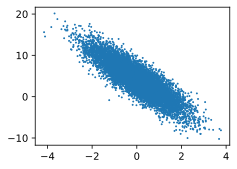

In [9]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1);

In [17]:
# 定义一个 data_iter 函数，该函数接受批量大小，特征矩阵和标签向量作为输入，生成大小为 batch_size 的小批量
def data_iter(batch_size, features, lables):
    num_examples = len(features)
    indices = list(range(num_examples)) # 生成 1-10000 列表
    
    
    # 这些样本是随机读取，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):   # step: batch_size
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])  # 取列表[i: i+batch_size] 生成张量
        
        # batch_indices 是 batch_size 随机数列表
        
        yield features[batch_indices], labels[batch_indices]    # yield = reurn
        
batch_size = 10
    
# features 是造的数据集 X，labels 是数据结果集 y
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break


tensor([[ 0.7095, -0.0324],
        [-0.8765, -0.8691],
        [-0.0218,  1.1782],
        [-0.8728,  2.1450],
        [ 0.6328, -3.1057],
        [-0.5146, -0.9136],
        [-0.1614,  1.2348],
        [ 1.3084,  2.3488],
        [-0.6599,  1.9817],
        [ 1.1632, -0.9680]]) 
 tensor([[ 5.7376],
        [ 5.4117],
        [ 0.1543],
        [-4.8421],
        [16.0151],
        [ 6.2695],
        [-0.3161],
        [-1.1727],
        [-3.8641],
        [ 9.8018]])


In [19]:
# 定义 初始化模型参数

# torch.normal 用于正态分布中抽取随机数，有参数（均值，标准差，用来存放抽取的随机数） 
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)    # size=（2，1） 表示生成的张量大小为2行1列
b = torch.zeros(1, requires_grad=True)

w, b

(tensor([[ 0.0051],
         [-0.0142]], requires_grad=True),
 tensor([0.], requires_grad=True))

In [20]:
# 定义模型
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [21]:
# 定义损失函数
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2 

In [28]:
# 定义优化算法
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()  # 在 torch 中，梯度是累加的，而不是替换的，因此需要梯度清除

In [29]:
# 训练过程
lr = 0.03 
num_epochs = 3  # 迭代3次
net = linreg    
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)   # 'X' 和 'y' 的小批量损失
        # 因为 'l' 形状是 （'batch_size',1） 而不是一个标量， '1' 中的所有元素被加到
        # 并以此计算关于 ['w','b']的梯度
        l.sum().backward() # 想计算损失函数相对于模型中所有参数的梯度
        sgd([w, b], lr, batch_size) # 使用参数的梯度更新
    
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean())}')

epoch 1, loss 4.928559428662993e-05
epoch 2, loss 4.929319766233675e-05
epoch 3, loss 4.946370609104633e-05


In [32]:
# 比较真实参数和通过训练学到的参数来估计训练的成功程度
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([-0.0005,  0.0003], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0007], grad_fn=<RsubBackward1>)
